## Snoqualmie falls data analysis

In [1]:
# import useful libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from IPython.display import Image
from scipy.stats import beta as sp_beta
from scipy.stats import gamma
%matplotlib inline

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# load the data
sqfalls = pd.read_csv("snoqualmie_falls_january.csv")
jan1st = sqfalls['January1']
sqfalls.drop(sqfalls.columns[0], axis=1, inplace=True)
sqfalls.index = np.arange(1948, 1984)
sqfalls.head()

,January1,January2,January3,January4,January5,January6,January7,January8,January9,January10,...,January22,January23,January24,January25,January26,January27,January28,January29,January30,January31
1948,136,100,16,80,10,66,88,38,1,87,...,33,8,16,1,0,0,0,5,16,4
1949,17,14,0,0,1,11,90,6,0,0,...,0,0,0,0,13,1,0,0,3,0
1950,1,35,13,13,18,122,22,25,8,48,...,84,63,19,4,46,6,3,0,0,0
1951,34,183,11,20,11,0,9,1,0,3,...,24,7,50,68,30,3,0,0,0,0
1952,0,0,2,1,2,7,11,2,37,21,...,5,6,64,2,16,13,0,3,155,18


In [3]:
# let's first focus on January 1st
jan1st_binary = np.where(jan1st > 0, 1, jan1st) # 0: not rain; 1: rain
jan1st_binary

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1])

### Use a Bernoulli model to predit whether or not it will rain on January 1st

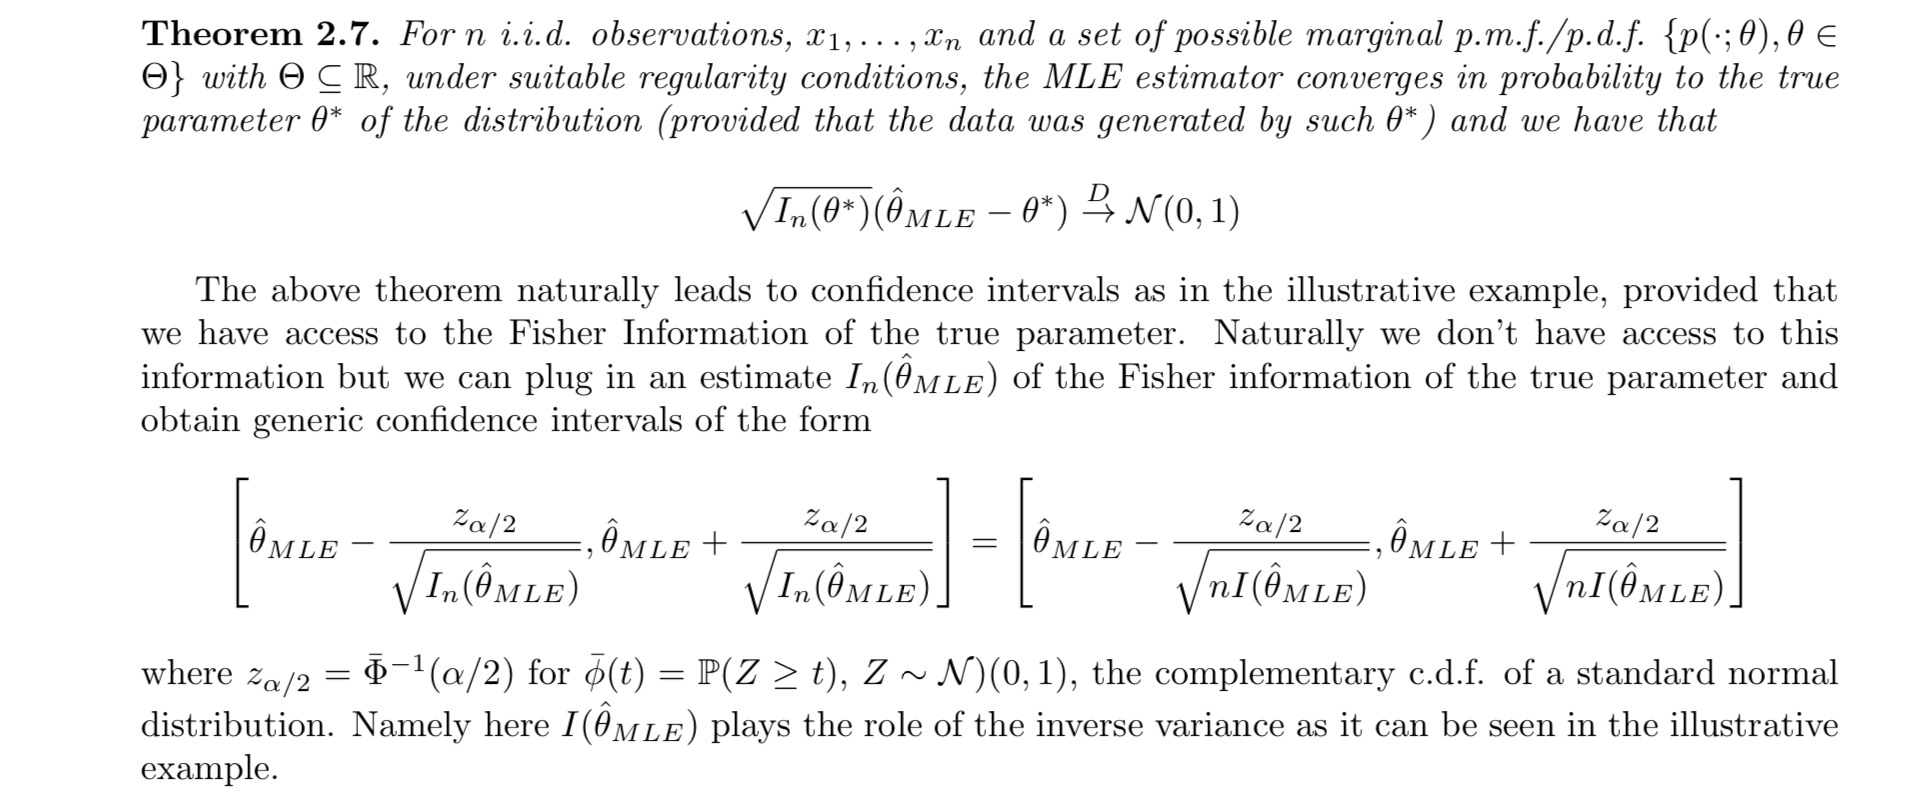

In [4]:
Image(filename='confidence_interval.jpeg')

In [5]:
# Assume that the weather on Jan 1st is independent across the year

# Calculate MLE of p
p_mle = np.mean(jan1st_binary)
print("the MLE of p is", round(p_mle, 2))
# Calculate standard error SE
se = np.sqrt(p_mle * (1 - p_mle) / len(jan1st_binary))
# Confidence level
alpha = 0.05
# Calculate z_alpha for the two-tailed test
z_alpha = norm.ppf(1 - alpha / 2)

# Construct a symmetric 95% confidence interval for p
lower_bound = p_mle - z_alpha * se # se = 1/sqrt(fisher information)
upper_bound = p_mle + z_alpha * se

print("95% confidence interval for p: [", round(lower_bound, 2), ",", round(upper_bound, 2), "]")

the MLE of p is 0.69
95% confidence interval for p: [ 0.54 , 0.84 ]


***Construct a Wald test to test the null hypothesis H0 : p = 1/2 versus H1 : p != 1/2 at significance alpha = 0.5***

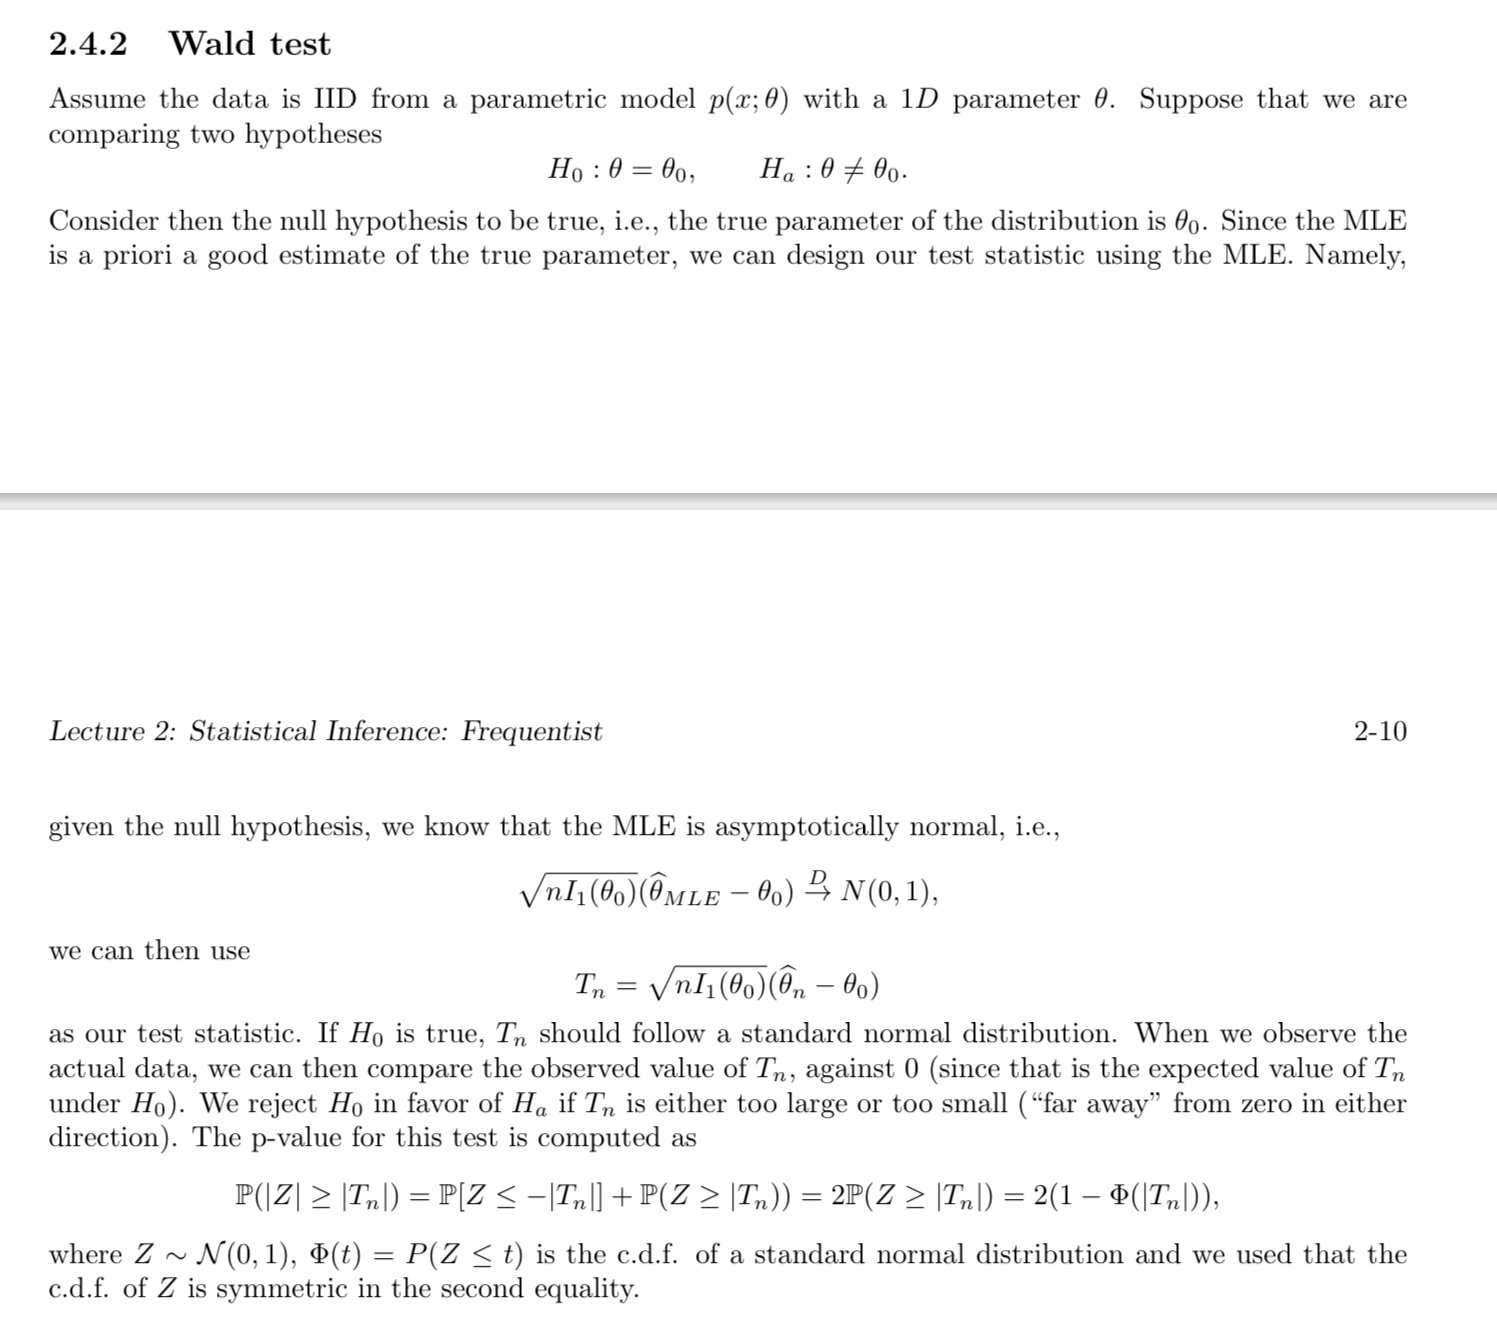

In [6]:
Image(filename='/Users/lexie_chen/Desktop/求职/Python/wald_test.jpeg')
# one-sample test

In [7]:
x = np.sum(jan1st_binary == 1)  # Number of rainy days
n = len(jan1st_binary)  # Total observations
p_0 = 1 / 2
I_1 = -(-x / (p_0 ** 2) - (n - x) / ((1 - p_0) ** 2)) # fisher information
Z = np.sqrt(I_1) * (p_mle - p_0) # test statistic
alpha = 0.05  # Significance level
p_value = 2 * (1 - norm.cdf(np.abs(Z))) # two tail, or use: p_value = 2 * norm.cdf(-np.abs(Z)) 

print("Z =", round(Z, 2))
print("p-value =", round(p_value, 2))

if p_value < alpha:
    print('Reject null hypothesis')
else:
    print("Can't reject null hypothesis")

Z = 2.33
p-value = 0.02
Reject null hypothesis


***Use a Bayesian approach to predict whether or not it will rain.***

Suppose that X | p ∼ Bernoulli(p) with prior p ∼ Beta(100,100)

In [8]:
# prior parameters
alpha = 100
beta = 100
n = len(jan1st_binary)

# posterior mean
posterior_mean = (alpha + np.sum(jan1st_binary)) / (alpha + beta + n)
# MAP estimate
map_estimate = (alpha + np.sum(jan1st_binary) - 1) / (alpha + beta + n - 2)
# confidence interval
confidence_interval = sp_beta.ppf([0.025, 0.975], alpha + np.sum(jan1st_binary), beta + n - np.sum(jan1st_binary))

# print the result
print("posterior_mean:", posterior_mean.round(3))
print("MAP:", map_estimate.round(3))
print("95% Confidence interval for p: [", confidence_interval[0].round(3), ",", confidence_interval[1].round(3), "]")

posterior_mean: 0.53
MAP: 0.53
95% Confidence interval for p: [ 0.466 , 0.593 ]


In situations where the posterior distribution is symmetric and unimodal (like a normal distribution), the posterior mean and the MAP estimate might be very close to each other. However, in more complex or skewed distributions, they might differ considerably.

- ***posterior mean :*** calculated by integrating the parameter values weighted by their respective posterior probabilities.
- ***MAP estimate :*** focuses on finding the single most likely value.

### Next, we model the amount of rain on January 1st using an Exponential distribution:
Let X := “amount of rain on Janurary 1st in 1/100th inch” ∼ Exp(λ).

- (𝜆) is the probability of rainfall on 1st Jan of each year
- (1/𝜆) is the average time interval between 2 rainy day

In [9]:
# Compute the MLE of 1/lambda = Sn / n
Sn = np.sum(jan1st)
lambda_mle = len(jan1st) / Sn  # lambda
one_over_lambda_mle = Sn / len(jan1st)  # 1/lambda

print("the MLE of 1/lambda:", round(one_over_lambda_mle, 2))

the MLE of 1/lambda: 27.06


In [10]:
# Construct a symmetric 95% confidence interval for 1/lambda.
In_lambda_over_1 = len(jan1st) * (lambda_mle**2)  # Fisher information
z_alpha = norm.ppf(1 - alpha / 2)  # z-value for alpha level

# Calculate lower and upper bounds for the confidence interval
lowerbound = 1 / lambda_mle - z_alpha / np.sqrt(In_lambda_over_1)
upperbound = 1 / lambda_mle + z_alpha / np.sqrt(In_lambda_over_1)

print("95% confidence interval for 1/λ: [", round(lowerbound, 2), ",", round(upperbound, 2), "]")

95% confidence interval for 1/λ: [ nan , nan ]


***Use a Bayesian approach to predict whether or not it will rain.***

Suppose that X | λ ∼ Exponential(λ) with prior λ ∼ Gamma(1,1).

In [11]:
# Prior parameters
alpha_prior = 1
beta_prior = 1

# Calculate the posterior parameters
posterior_alpha = alpha_prior + len(jan1st)
posterior_beta = beta_prior + np.sum(jan1st)

# Calculate the posterior mean for 1/λ
one_over_lambda_posterior_mean = posterior_beta / posterior_alpha

# Calculate the 95% credible interval for λ
credible_interval = gamma.ppf([0.025, 0.975], posterior_alpha, scale=1/posterior_beta)

# Print results
print("Posterior Mean for 1/λ:", one_over_lambda_posterior_mean.round(3))
print("95% Credible Interval for 1/λ:", (1 / credible_interval[::-1]).round(3))

Posterior Mean for 1/λ: 26.351
95% Credible Interval for 1/λ: [19.563 37.426]


***Test H0 : 1/lambda = 0.25inch versus H1 : 1/lambda  != 0.25inch***

In [12]:
one_over_lambda_0 = 0.25 * 100 # unit conversion

I1_l0 = n / (one_over_lambda_0 ** 2)
T_n = np.sqrt(n * I1_l0) * (one_over_lambda_mle - one_over_lambda_0)
p_value = 2 * (1 - norm.cdf(np.abs(T_n)))  # two-tail 
alpha = 0.05

print("p-value:", round(p_value, 4))

if p_value < alpha:
    print('Reject null hypothesis')
else:
    print("Can't reject null hypothesis")

p-value: 0.0031
Reject null hypothesis


***Test H0 : 1/λ ≥ 0.25inch versus H1 : 1/λ < 0.25inch***

左尾：备选假设包含" < "，即为左尾检验。
右尾：备选假设包含" > "，即为右尾检验。

In [13]:
p_value = norm.cdf(abs(T_n))  # left-tail

if p_value < alpha:
    print('Reject null hypothesis')
else:
    print("Can't reject null hypothesis")

print("p-value:", round(p_value, 4))

Can't reject null hypothesis
p-value: 0.9985


***Re-compute the confidence intervals of X ~ Ber(p) and X ~ Exp(λ) using the bootstrap.***

In [14]:
# Define bootstrap function
def bootstrap_sample(data):
    n = len(data)
    indices = np.random.choice(np.arange(0, n), size=n, replace=True)
    return data[indices]

# Number of bootstrap repetitions
n_bootstrap = 30
bootstrap_means = []
bootstrap_one_over_lambda = []

# Calculate means for 30 bootstrap samples
for i in range(n_bootstrap):
    bootstrap_sample_data = bootstrap_sample(jan1st_binary)
    bootstrap_means.append(np.mean(bootstrap_sample_data))

# Calculate 95% confidence interval for means
confidence_interval_means = np.percentile(bootstrap_means, [2.5, 97.5])
print("95% confidence interval for means:", confidence_interval_means.round(3))


for i in range(n_bootstrap):
    bootstrap_sample_data = bootstrap_sample(jan1st)
    Sn = np.sum(bootstrap_sample_data)
    one_over_lambda = Sn / len(bootstrap_sample_data)
    bootstrap_one_over_lambda.append(one_over_lambda)

# Calculate 95% confidence interval for 1/lambda
confidence_interval_one_over_lambda = np.percentile(bootstrap_one_over_lambda, [2.5, 97.5])
print("95% confidence interval for 1/lambda:", confidence_interval_one_over_lambda.round(3))

95% confidence interval for means: [0.548 0.813]
95% confidence interval for 1/lambda: [13.991 46.147]


Recall: 
- 95% confidence interval for p: [ 0.54 , 0.84 ]
- 95% confidence interval for 1/λ: [ 18.22 , 35.89 ]

For the Bernoulli parameter similar interval should be observed, while for the exponential model the bootstrap interval is wider.

The Bernoulli model ignores the amount of rain information and only predicts if there is rain or not. 
The exponential model may not fit the observed distribution of rain, especially the empirical distribution can be bimodal. Also, the memoryless property of the exponential distribution can be questionable.

-> the Bernoulli and the Exponential models are overly simplistic

### Markov Chain
Plot a matrix whose columns are days of the month and rows the year. Fill a cell with black if the day was wet or leave it white if the day was dry.

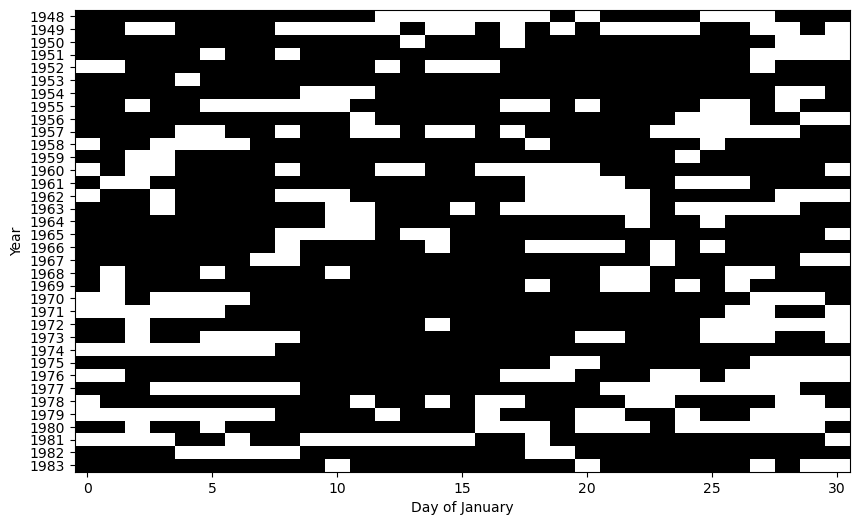

In [15]:
sqfalls_binary = np.where(sqfalls > 0, 1, 0)

plt.figure(figsize=(10, 6)) 
plt.imshow(sqfalls_binary, cmap='binary', aspect='auto')
plt.yticks(np.arange(0, len(sqfalls)), np.arange(1948, 1984)) 
plt.xlabel('Day of January')
plt.ylabel('Year')
plt.show()

Simulate dry/wet days of January for years 1948-1983 with a Bernoulli r.v. with parameter p and plot it as in the first question.

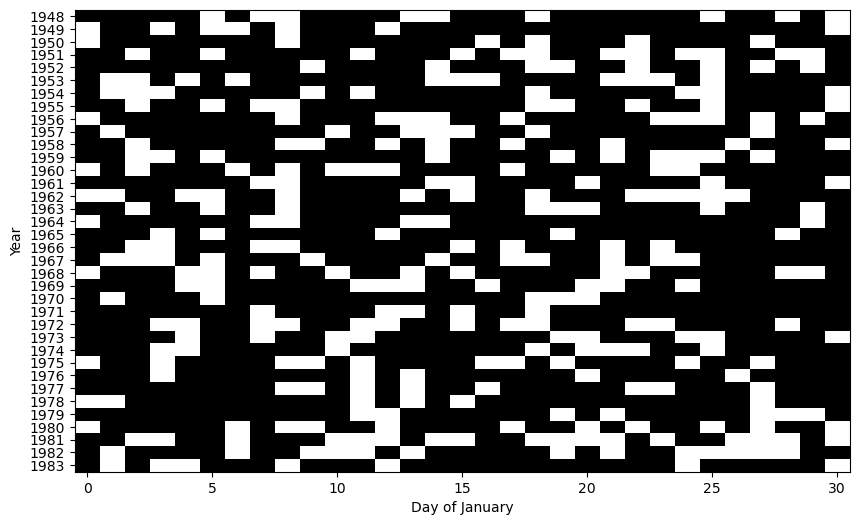

In [16]:
np.random.seed(101)

n_years = 36
n_days = 31

p_hat = np.mean(sqfalls_binary)
simulated_data = np.random.binomial(1, p_hat, size=n_years * n_days)
simulated_matrix = np.reshape(simulated_data, (n_years, n_days))

plt.figure(figsize=(10, 6)) 
plt.imshow(simulated_matrix, cmap='binary', aspect='auto')
plt.yticks(np.arange(0, len(sqfalls)), np.arange(1948, 1984)) 
plt.xlabel('Day of January')
plt.ylabel('Year')
plt.show()

Model the data as a ***one-step*** homogeneous Markov chain (one-step meaning that the distribution of a day only depends on the previous day, a two-step memory would mean that it would depend on the two previous days). Estimate the transition probabilities under this model.

In [17]:
wet_to_wet = 0
wet_to_dry = 0
dry_to_wet = 0
dry_to_dry = 0

# 计算状态转移次数
for i in range(len(sqfalls_binary)):
    for j in range(len(sqfalls_binary[i]) - 1):
        if sqfalls_binary[i, j] == 0 and sqfalls_binary[i, j + 1] == 0:
            dry_to_dry += 1
        if sqfalls_binary[i, j] == 0 and sqfalls_binary[i, j + 1] == 1:
            dry_to_wet += 1
        if sqfalls_binary[i, j] == 1 and sqfalls_binary[i, j + 1] == 1:
            wet_to_wet += 1
        if sqfalls_binary[i, j] == 1 and sqfalls_binary[i, j + 1] == 0:
            wet_to_dry += 1

prob_wet_to_wet = wet_to_wet / (wet_to_wet + wet_to_dry)
prob_wet_to_dry = wet_to_dry / (wet_to_wet + wet_to_dry)
prob_dry_to_wet = dry_to_wet / (dry_to_wet + dry_to_dry)
prob_dry_to_dry = dry_to_dry / (dry_to_wet + dry_to_dry)

transition_matrix = np.array([[prob_wet_to_wet, prob_wet_to_dry], [prob_dry_to_wet, prob_dry_to_dry]])

states = ["wet", "dry"]
transition_matrix = pd.DataFrame(transition_matrix, index=states, columns=states)

transition_matrix

,wet,dry
wet,0.833982,0.166018
dry,0.398058,0.601942


Compute the ***n-step*** transition probability after n = 2,3,...,20 days. After how many days does the model become completely uninformative and useless (i.e. as good as a random guess compared to the actual data)?

In [18]:
import numpy as np
result_matrix = transition_matrix.copy()
day = 1

for n in range(2, 21):
    result_matrix = np.dot(transition_matrix, result_matrix)
    day += 1
    print(f'Day {day}')
    print(result_matrix)

Day 2
[[0.76161061 0.23838939]
 [0.57158123 0.42841877]]
Day 3
[[0.73006228 0.26993772]
 [0.647224   0.352776  ]]
Day 4
[[0.71630962 0.28369038]
 [0.68019846 0.31980154]]
Day 5
[[0.71031451 0.28968549]
 [0.69457281 0.30542719]]
Day 6
[[0.70770111 0.29229889]
 [0.70083892 0.29916108]]
Day 7
[[0.70656186 0.29343814]
 [0.70357047 0.29642953]]
Day 8
[[0.70606523 0.29393477]
 [0.70476122 0.29523878]]
Day 9
[[0.70584874 0.29415126]
 [0.70528029 0.29471971]]
Day 10
[[0.70575437 0.29424563]
 [0.70550657 0.29449343]]
Day 11
[[0.70571323 0.29428677]
 [0.70560521 0.29439479]]
Day 12
[[0.7056953  0.2943047 ]
 [0.70564821 0.29435179]]
Day 13
[[0.70568748 0.29431252]
 [0.70566695 0.29433305]]
Day 14
[[0.70568407 0.29431593]
 [0.70567512 0.29432488]]
Day 15
[[0.70568259 0.29431741]
 [0.70567868 0.29432132]]
Day 16
[[0.70568194 0.29431806]
 [0.70568024 0.29431976]]
Day 17
[[0.70568166 0.29431834]
 [0.70568091 0.29431909]]
Day 18
[[0.70568153 0.29431847]
 [0.70568121 0.29431879]]
Day 19
[[0.70568148 0.

After 13 days, the differences between current and preceding n_step Transitional Probability Matrices is less than 0.0001. In practical terms, the model becomes uninformative around this point.

Simulate the Markov chain by simulating January 1 from starting from an initial distribution.

Initial distribution: rain: 0.694; no rain: 0.306

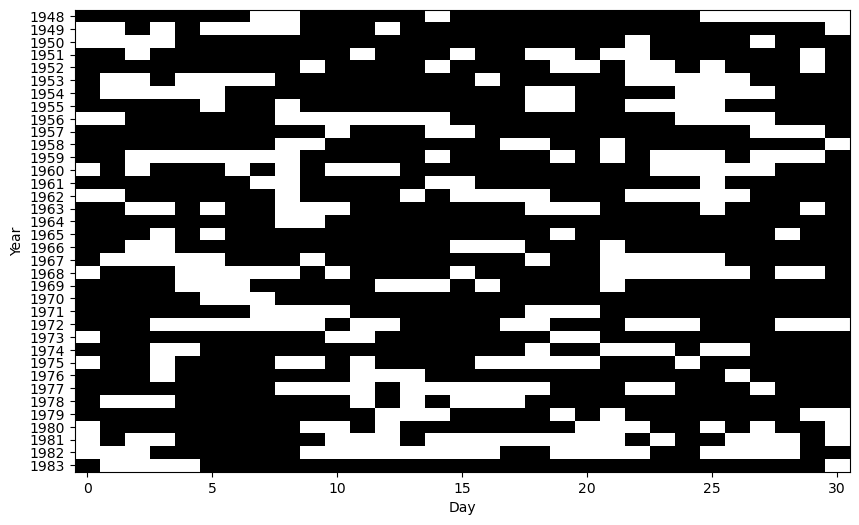

In [46]:
# Define initial distribution
initial_distribution = np.array([0.694, 0.306])

# Define transition probability matrix
transition_matrix = np.array([[prob_wet_to_wet, prob_wet_to_dry],
                              [prob_dry_to_wet, prob_dry_to_dry]]) # one-step

np.random.seed(101)
current_state = np.random.choice([0, 1], size=1, p=initial_distribution)
states1 = [current_state[0]]

num_steps = 36 * 31 - 1  # 15 years 31 days
for i in range(num_steps):
    current_state = np.random.choice([0, 1], size=1, p=transition_matrix[current_state, :][0])
    states1.append(current_state[0])

# Print the simulated Markov Chain
# print("Simulated Markov Chain:", states)

# Plot the simulated Markov Chain
plt.figure(figsize=(10, 6)) 
states_matrix1 = np.array(states1).reshape(36, 31)
plt.yticks(np.arange(0, len(sqfalls)), np.arange(1948, 1984)) 
plt.imshow(states_matrix1, cmap='gray', aspect='auto')
plt.xlabel('Day')
plt.ylabel('Year')
plt.show()

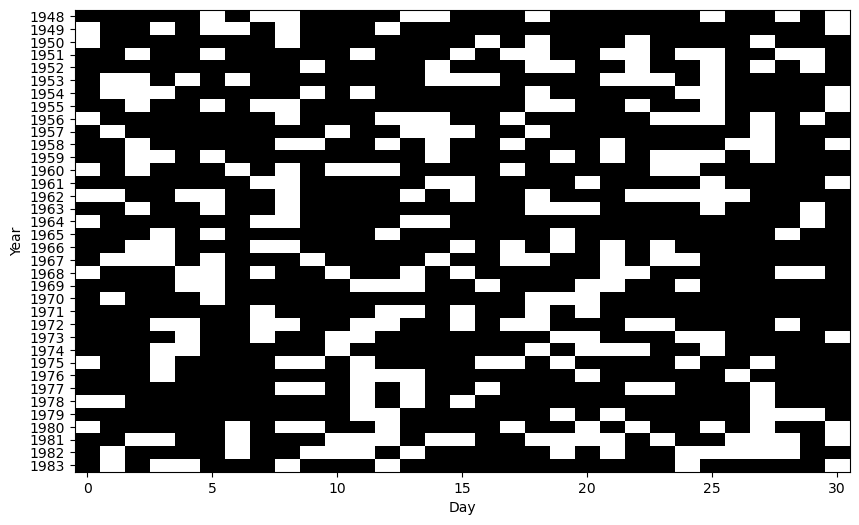

In [45]:
# Define initial distribution
initial_distribution = np.array([0.694, 0.306])

# Define transition probability matrix
transition_matrix = np.array([[0.70568748, 0.29431252],
                              [0.70566695, 0.29433305]]) # 13-step

np.random.seed(101)
current_state = np.random.choice([0, 1], size=1, p=initial_distribution)
states2 = [current_state[0]]

num_steps = 36 * 31 - 1  # 15 years 31 days
for i in range(num_steps):
    current_state = np.random.choice([0, 1], size=1, p=transition_matrix[current_state, :][0])
    states2.append(current_state[0])

# Print the simulated Markov Chain
# print("Simulated Markov Chain:", states)

# Plot the simulated Markov Chain
plt.figure(figsize=(10, 6)) 
states_matrix2 = np.array(states2).reshape(36, 31)
plt.yticks(np.arange(0, len(sqfalls)), np.arange(1948, 1984)) 
plt.imshow(states_matrix2, cmap='gray', aspect='auto')
plt.xlabel('Day')
plt.ylabel('Year')
plt.show()

In [52]:
# one-step
num_same_elements = np.sum(states_matrix1 == sqfalls_binary)
total_elements = states_matrix1.size

percent_same_elements = (num_same_elements / total_elements) * 100
percent_same_elements

43.45878136200717

In [51]:
# 13-step
num_same_elements2 = np.sum(states_matrix2 == sqfalls_binary)
total_elements2 = states_matrix2.size

percent_same_elements2 = (num_same_elements2 / total_elements2) * 100
percent_same_elements2

40.50179211469534